# Loading the necessary libraries

In [1]:
import numpy as np
import os
import glob
import tensorflow as tf
import argparse
import random
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import utils
import model_files


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading a trained model

In [2]:
# model = model_files.create_efficientnet_model()
# model.compile(optimizer='adam',
#                     loss='binary_crossentropy',                    
#                     metrics=['accuracy'])
# model.load_weights('experiments/new_experiment/weights.18-0.7798.hdf5')
# model.summary()

model = model_files.tf_enet_model()
model.load_weights('experiments/extended_training/weights.25-0.8174.hdf5')

model.summary()
data_json = utils.read_json('experiments/extended_training/hyperparameters.json')

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

# Load the last convolutional (2D) layer from the trained model

In [3]:
base_model = model.get_layer('efficientnet-b0')
last_conv_layer = base_model.get_layer('top_activation')

Text(0.5, 0, 'Score: [[0.760208   0.11051573]] \nAnswer: elbow_fracture_1.jpg\nPrediction: Abnormal')

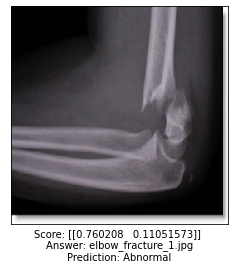

In [4]:
def produce_model_inputs(img_path, data_json):
    # Read the image and resize it
    #img = image.load_img(img_path, target_size=(height, width))
    img = image.load_img(img_path, target_size=(data_json['image_dims'], data_json['image_dims']))
    # Convert it to a Numpy array with target shape.
    image_array = image.img_to_array(img)
    normalised_image = image_array/255.

    # model_input has shape [1, 256, 256, 3]
    model_input = tf.expand_dims(normalised_image,axis=0)
    return model_input


def predict_image(model_input, model):    
    prediction = model(model_input)    

    if tf.argmax(prediction,axis=-1)[0] == 0:
        result = 'Abnormal'
    elif tf.argmax(prediction,axis=-1)[0] == 1:
        result = 'Normal'

    return prediction, result

# sample_image_path = 'elbow_data/SABINE 114 size test set/001_Normal011.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/002_Abnormal001.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/003_Abnormal009.jpg'
# sample_image_path = 'sample_images/elbow_broken.jpeg'
sample_image_path = 'sample_images/elbow_fracture_1.jpg'

model_input = produce_model_inputs(sample_image_path, data_json)
prediction, result = predict_image(model_input,model)
plt.imshow(model_input[0])
plt.xticks([])
plt.yticks([])
plt.xlabel(f'Score: {prediction} \nAnswer: {os.path.basename(sample_image_path)}\nPrediction: {result}')

# Produce the data generator

In [11]:
test_dir = 'elbow_data/Clean_Data/ActualTestSet'

base_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


test_data_gen = base_image_generator.flow_from_directory(batch_size=10,
                                                        directory=test_dir,
                                                        shuffle=False,
                                                        # target_size=(224, 224),
                                                        target_size=(256, 256),
                                                        class_mode='categorical',
                                                        )


Found 112 images belonging to 2 classes.


# Evaluate the model performance

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    # loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(
        num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
        dtype=None, thresholds=None, multi_label=False, label_weights=None)
        ])
# metrics=[metrics.accuracy_metric,metrics.no_bg_accuracy_metric, metrics.dice_2_metric])
                        
results = model.evaluate(test_data_gen)

12/12 [==============================] - 1s 65ms/step - loss: 0.4841 - accuracy: 0.7679 - auc_1: 0.8472


# New Validatation Set

In [74]:
new_test_dir = 'elbow_data/Clean_Data/ActualTestSet'
# new_test_dir = 'elbow_data/Clean_Data/SecondTestSet'

base_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


new_test_data_gen = base_image_generator.flow_from_directory(batch_size=10,
                                                        directory=new_test_dir,
                                                        shuffle=False,
                                                        target_size=(256, 256),
                                                        # target_size=(224, 224),
                                                        # class_mode='categorical',
                                                        class_mode='binary',
                                                        )


Found 112 images belonging to 2 classes.


In [75]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=[
#         'accuracy',
#         tf.keras.metrics.AUC(
#         num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
#         dtype=None, thresholds=None, multi_label=False, label_weights=None)
#         ])

                        
results = model.evaluate(new_test_data_gen)

12/12 [==============================] - 1s 62ms/step - loss: 0.4841 - accuracy: 0.7679 - auc_1: 0.8472


# Visualise the heatmap

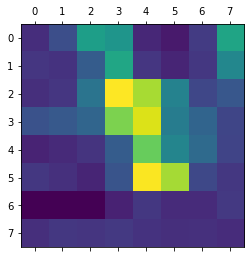

In [38]:
def make_gradcam_heatmap(
    img_array,
    model,
    base_model_name,
    base_activation_layer,
    base_final_layers,
    classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    base_model = model.get_layer(base_model_name)
    last_activation_layer = base_model.get_layer(base_activation_layer)
    last_conv_layer_model = tf.keras.Model(base_model.inputs, last_activation_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_activation_layer.output.shape[1:])
    x = classifier_input
    for layer_name in base_final_layers:
        x = base_model.get_layer(layer_name)(x)
    
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)

    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature lbow_data/SABINE 114 size test set/004_Normal022.jpgap
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


# Make model
# model = model_builder(weights="imagenet")
base_model_name = 'efficientnet-b0'
base_activation_layer = 'top_activation'
base_final_layers = [
    'avg_pool',
    'top_dropout',
    'probs'
]
classifier_layer_names = [
    'first_layer',
    'second_layer',
    'classification_layer'
]


# Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

img_array = produce_model_inputs(sample_image_path, data_json)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    base_model_name,
    base_activation_layer,
    base_final_layers,
    classifier_layer_names
)


# Display heatmap
plt.matshow(heatmap)

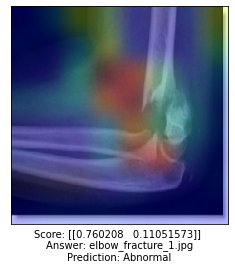

In [35]:
# We load the original image
img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(data_json['image_dims'],data_json['image_dims']))
img = tf.keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

model_input = produce_model_inputs(sample_image_path, data_json)
prediction, result = predict_image(model_input,model)

plt.imshow(superimposed_img)
plt.xticks([])
plt.yticks([])
plt.xlabel(f'Score: {prediction} \nAnswer: {os.path.basename(sample_image_path)}\nPrediction: {result}');

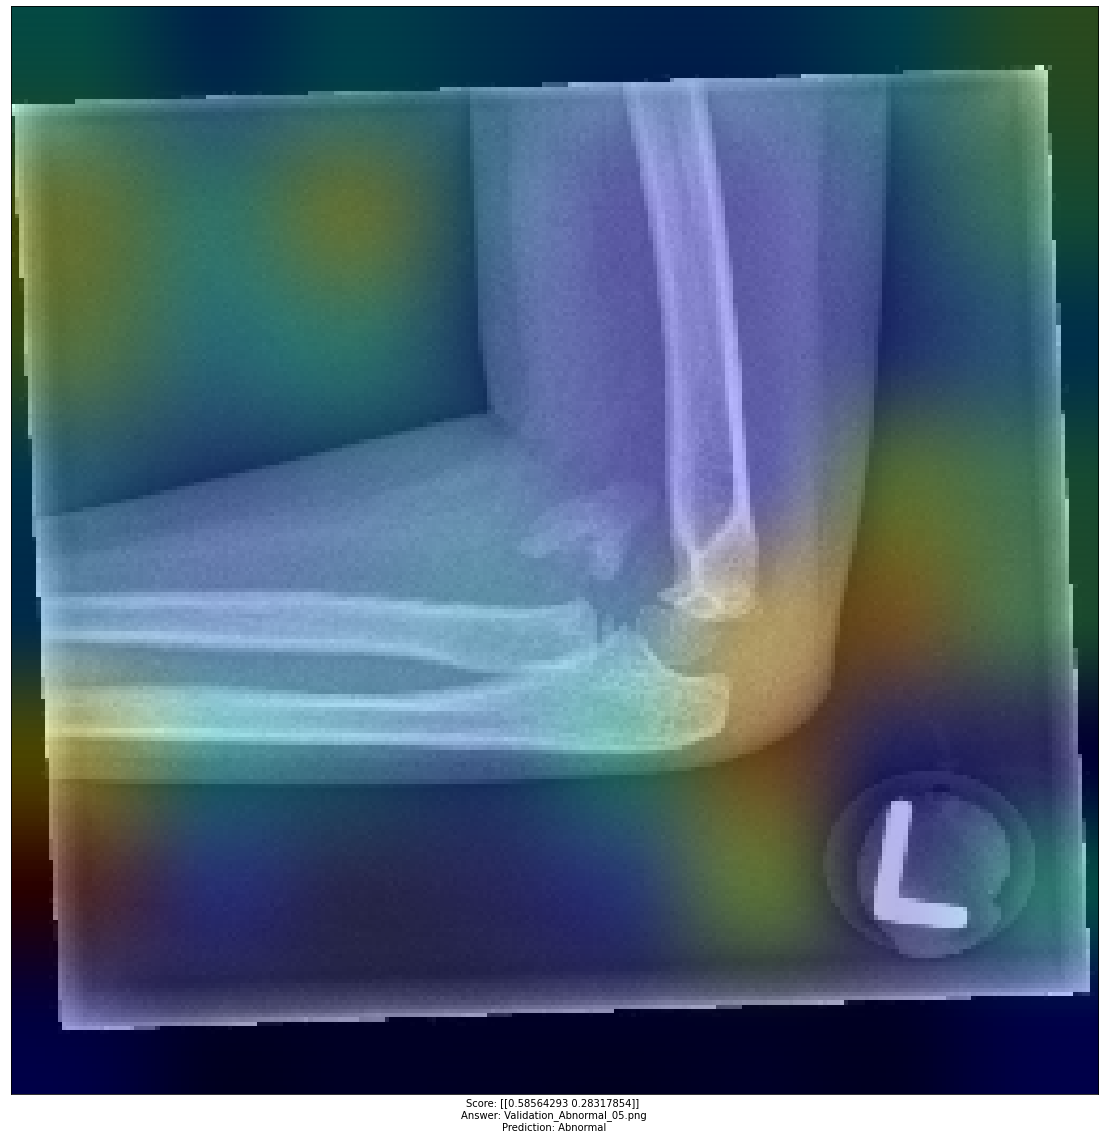

In [67]:
def overlay_heatmap(sample_image_path, heatmap):
    # We load the original image
    img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(data_json['image_dims'],data_json['image_dims']))
    img = tf.keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    model_input = produce_model_inputs(sample_image_path, data_json)
    prediction, result = predict_image(model_input,model)

    plt.figure(figsize=[20,20])
    plt.imshow(superimposed_img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Score: {prediction} \nAnswer: {os.path.basename(sample_image_path)}\nPrediction: {result}');

overlay_heatmap(sample_image_path, heatmap)


# Choose image here

In [69]:
# sample_image_path = 'elbow_data/SABINE 114 size test set/001_Normal011.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/002_Abnormal001.jpg'
# sample_image_path = 'elbow_data/SABINE 114 size test set/003_Abnormal009.jpg'

# sample_image_path = 'sample_images/elbow_broken.jpeg'
# sample_image_path = 'sample_images/elbow_fracture_1.jpg'

sample_image_path = 'elbow_data/Clean_Data/SecondTestSet/Abnormal/Validation_Abnormal_10.png'

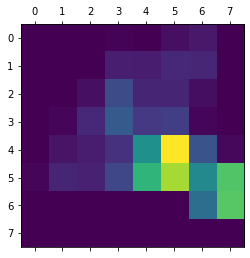

In [70]:

img_array = produce_model_inputs(sample_image_path, data_json)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    base_model_name,
    base_activation_layer,
    base_final_layers,
    classifier_layer_names
)


# Display heatmap
plt.matshow(heatmap)

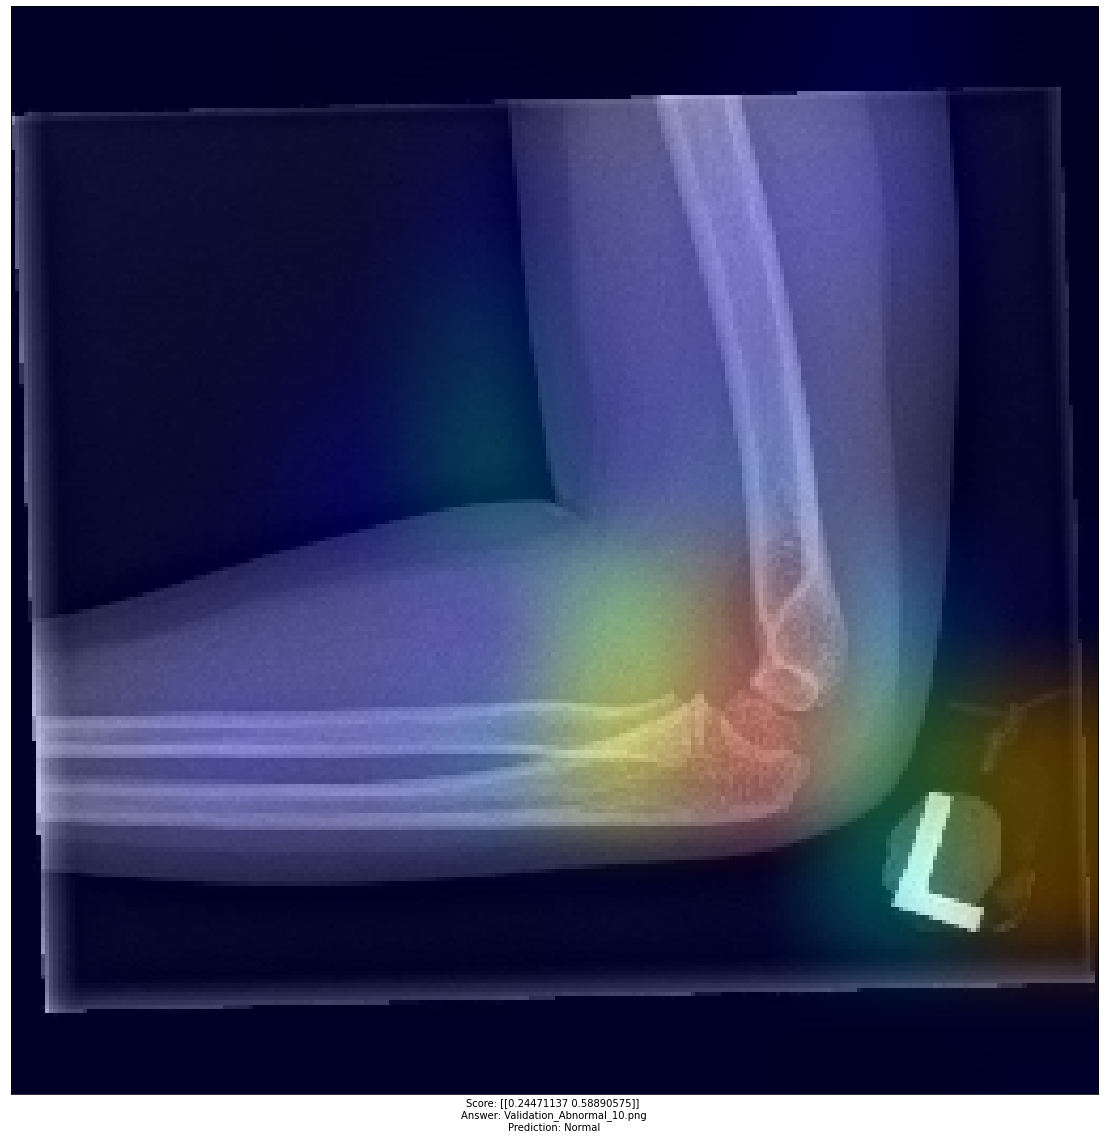

In [71]:
overlay_heatmap(sample_image_path, heatmap)